In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [71]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import pandas as pd
import numpy as np
df = pd.read_csv("/kaggle/input/football-final-dataset/1k_pos_sample.csv")
df2 = pd.read_csv("/kaggle/input/football-final-dataset/2k_neg_sample.csv")
df3 = pd.read_csv("/kaggle/input/football-final-dataset/new_100_pos_samples.csv")

df = pd.concat([df,df2,df3]).drop("Unnamed: 0",axis=1).reset_index(drop=True)

feats = ['injuried', 'prev_player_age', 'prev_player_height', 'prev_player_weight', 'prev_games_appearences', 'prev_games_lineups', 'prev_games_minutes', 'prev_games_number', 'prev_games_position', 'prev_games_rating', 'prev_substitutes_in', 'prev_substitutes_out', 'prev_substitutes_bench', 'prev_shots_total', 'prev_shots_on', 'prev_goals_total', 'prev_goals_conceded', 'prev_goals_assists', 'prev_goals_saves', 'prev_passes_total', 'prev_passes_key', 'prev_passes_accuracy', 'prev_tackles_total', 'prev_tackles_blocks', 'prev_tackles_interceptions', 'prev_duels_total', 'prev_duels_won', 'prev_dribbles_attempts', 'prev_dribbles_success', 'prev_dribbles_past', 'prev_fouls_drawn', 'prev_fouls_committed', 'prev_cards_yellow', 'prev_cards_yellowred', 'prev_cards_red', 'prev_penalty_won', 'prev_penalty_commited', 'prev_penalty_scored', 'prev_penalty_missed', 'prev_penalty_saved', 'player_minutes_avg_5', 'player_rating_avg_5', 'player_shots_total_5', 'player_shots_on_5', 'player_goals_5', 'player_assists_5', 'player_fouls_committed_5', 'player_fouls_drawn_5', 'player_yellow_cards_5', 'player_red_cards_5', 'player_duels_total_5', 'player_duels_won_5', 'player_passes_total_5', 'player_passes_key_5', 'player_tackles_total_5', 'player_tackles_blocks_5', 'player_tackles_interceptions_5', 'player_duels_win_ratio_5', 'player_pass_acc_mean_5', 'team_shots_on_goal_5', 'team_shots_off_goal_5', 'team_total_shots_5', 'team_fouls_5', 'team_corners_5', 'team_offsides_5', 'team_ball_poss_avg_5', 'team_yellow_cards_5', 'team_red_cards_5', 'team_passes_5', 'team_passes_acc_5', 'team_pass_acc_ratio_5', 'opp_shots_on_goal_5', 'opp_shots_off_goal_5', 'opp_total_shots_5', 'opp_fouls_5', 'opp_corners_5', 'opp_offsides_5', 'opp_ball_poss_avg_5', 'opp_yellow_cards_5', 'opp_red_cards_5', 'opp_passes_5', 'opp_passes_acc_5', 'opp_pass_acc_ratio_5', 'days_since_last_injury', 'inj_count_last_6m', 'team_vs_opp_shots_diff_5', 'team_vs_opp_sog_diff_5', 'team_vs_opp_fouls_diff_5', 'team_vs_opp_corners_diff_5', 'team_vs_opp_offsides_diff_5', 'team_vs_opp_poss_diff_5', 'team_vs_opp_pass_acc_diff_5', 'team_vs_opp_shots_ratio_5', 'team_vs_opp_sog_ratio_5', 'team_vs_opp_fouls_ratio_5', 'team_vs_opp_corners_ratio_5', 'team_vs_opp_offsides_ratio_5', 'team_vs_opp_poss_ratio_5', 'team_vs_opp_pass_acc_ratio_5',"player_id"]
df = df[feats]

df["prev_player_height"] = df["prev_player_height"].fillna("-1 cm").apply(lambda x: int(x.split()[0])).replace({-1:np.nan})
df["prev_player_weight"] = df["prev_player_weight"].fillna("-1 kg").apply(lambda x: int(x.split()[0])).replace({-1:np.nan})
df["prev_games_position"] = df["prev_games_position"].fillna("None")

In [72]:
def clean_data(df, target_col):
    # Drop useless columns
    nunique = df.nunique(dropna=False)
    to_drop = nunique[nunique <= 1].index.tolist()
    to_drop += df.columns[df.isna().all()].tolist()
    to_drop = list(set(to_drop) - {target_col})
    df = df.drop(columns=to_drop)
    
    # Label encode object columns
    for col in df.select_dtypes(include='object').columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    
    return df


df = clean_data(df, "injuried")
df

,injuried,prev_player_age,prev_player_height,prev_player_weight,prev_games_appearences,prev_games_lineups,prev_games_minutes,prev_games_position,prev_games_rating,prev_substitutes_in,...,team_vs_opp_poss_diff_5,team_vs_opp_pass_acc_diff_5,team_vs_opp_shots_ratio_5,team_vs_opp_sog_ratio_5,team_vs_opp_fouls_ratio_5,team_vs_opp_corners_ratio_5,team_vs_opp_offsides_ratio_5,team_vs_opp_poss_ratio_5,team_vs_opp_pass_acc_ratio_5,player_id
0,1,31.0,189.0,77.0,33.0,33.0,2939.0,2,6.969696,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1557
1,1,31.0,189.0,77.0,33.0,33.0,2939.0,2,6.969696,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1557
2,1,31.0,189.0,77.0,33.0,33.0,2939.0,2,6.969696,0.0,...,11.0,0.083478,1.363636,1.166667,1.583333,3.500000,NaN,1.207547,1.102213,1557
3,1,31.0,189.0,77.0,33.0,33.0,2939.0,2,6.969696,0.0,...,25.5,0.127389,4.142857,3.250000,2.066667,3.250000,1.500000,1.653846,1.167544,1557
4,1,34.0,184.0,70.0,3.0,3.0,226.0,1,6.566666,0.0,...,-3.5,-0.054842,2.235294,1.777778,2.600000,2.200000,0.250000,0.945312,0.940172,1561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3564,1,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66463
3565,1,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69539
3566,1,26.0,185.0,77.0,35.0,30.0,2815.0,1,7.082857,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70500
3567,1,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,70509


In [73]:
# ==== 2. TRAINING FUNCTION ====
def train_xgb_classifier(df, target_col='injuried', n_splits=5, f1_type='macro'):

    X = df.drop(columns=[target_col])
    y = df[target_col]

    skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    feature_importance_df = pd.DataFrame()
    
    # Collect OOF predictions
    oof_preds = np.zeros(len(X))

    print("Starting Stratified Group K-Fold Training with XGBoost...\n")

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y, groups=X["player_id"])):
        X_train = X.drop("player_id", axis=1).iloc[train_idx]
        X_val = X.drop("player_id", axis=1).iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        clf = XGBClassifier(
            n_estimators=80,
            learning_rate=0.1,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )

        clf.fit(X_train, y_train)
        preds = clf.predict(X_val)

        oof_preds[val_idx] = preds  # Collect OOF predictions

        # Feature importances
        fold_importance = pd.DataFrame()
        fold_importance['feature'] = X_train.columns
        fold_importance['importance'] = clf.feature_importances_
        fold_importance['fold'] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=0)

        print(f"Fold {fold + 1} done.")

    # ==== 3. OOF METRIC ====
    final_f1 = f1_score(y, oof_preds, average=f1_type)
    print(f"\nOverall OOF F1 ({f1_type}): {final_f1:.4f}")

    # ==== 4. AGGREGATE FEATURE IMPORTANCE ====
    mean_importance = feature_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False)

    # Plot
    top_feats = mean_importance.head(20)
    plt.figure(figsize=(10, 6))
    top_feats.plot(kind='barh')
    plt.title("Top 20 Feature Importances (XGBoost)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return mean_importance, oof_preds


In [74]:
from sklearn.metrics import accuracy_score

def evaluate_model_vs_baseline(true_labels, model_preds):
    # === BASELINE: Majority class ===
    majority_class = true_labels.mode()[0]
    baseline_preds = np.full_like(true_labels, fill_value=majority_class)

    # === METRICS ===
    model_acc = accuracy_score(true_labels, model_preds)
    model_f1 = f1_score(true_labels, model_preds, average='macro')

    baseline_acc = accuracy_score(true_labels, baseline_preds)
    baseline_f1 = f1_score(true_labels, baseline_preds, average='macro')

    # === PRINT RESULTS ===
    print("\n==== MODEL PERFORMANCE vs BASELINE ====")
    print(f"Model Accuracy     : {model_acc:.4f}")
    print(f"Model F1 (macro)   : {model_f1:.4f}")
    print(f"Baseline Accuracy  : {baseline_acc:.4f}")
    print(f"Baseline F1 (macro): {baseline_f1:.4f}")


Starting Stratified Group K-Fold Training with XGBoost...

Fold 1 done.
Fold 2 done.
Fold 3 done.
Fold 4 done.
Fold 5 done.

Overall OOF F1 (macro): 0.8001


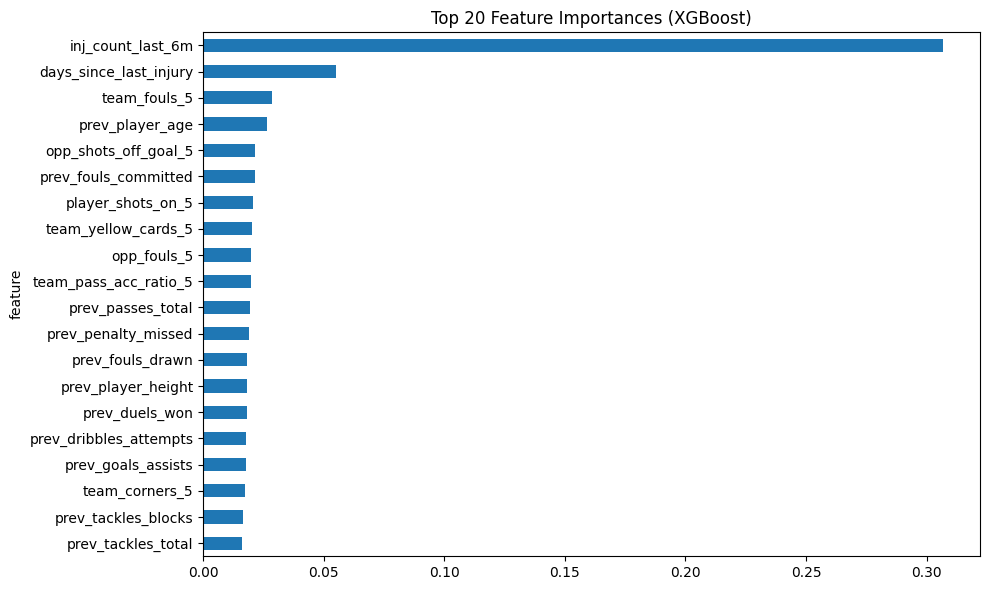


==== MODEL PERFORMANCE vs BASELINE ====
Model Accuracy     : 0.8465
Model F1 (macro)   : 0.8001
Baseline Accuracy  : 0.6926
Baseline F1 (macro): 0.4092


In [75]:
feats = ['inj_count_last_6m', 'days_since_last_injury', 'prev_player_age', 'team_pass_acc_ratio_5', 'prev_passes_total', 'prev_games_minutes', 'prev_goals_assists', 'prev_fouls_drawn', 'prev_tackles_total', 'prev_player_height', 'prev_penalty_missed', 'prev_dribbles_success', 'prev_fouls_committed', 'prev_tackles_blocks', 'prev_dribbles_attempts', 'prev_tackles_interceptions', 'team_yellow_cards_5', 'prev_player_weight', 'team_fouls_5', 'team_corners_5', 'team_shots_on_goal_5', 'opp_shots_off_goal_5', 'opp_fouls_5', 'opp_total_shots_5', 'team_vs_opp_sog_diff_5', 'prev_goals_saves', 'opp_pass_acc_ratio_5', 'prev_duels_won', 'opp_ball_poss_avg_5', 'opp_passes_acc_5', 'player_shots_on_5', 'team_vs_opp_offsides_ratio_5', 'team_vs_opp_fouls_diff_5', 'team_ball_poss_avg_5', 'team_passes_acc_5', 'team_passes_5', 'team_vs_opp_corners_ratio_5', 'player_duels_won_5', 'team_vs_opp_shots_diff_5', 'team_vs_opp_sog_ratio_5', 'team_shots_off_goal_5', 'team_vs_opp_poss_diff_5', 'opp_passes_5', 'team_vs_opp_pass_acc_ratio_5',"injuried","player_id"]

# Modify function to return oof_preds as well
importance, oof_preds = train_xgb_classifier(df[feats], target_col='injuried')

# Then run evaluation
evaluate_model_vs_baseline(df['injuried'], oof_preds)


# Features Selection via Permutation Importance

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


# ==== 2. TRAINING FUNCTION ====
def train_xgb_with_permutation_importance(df, target_col='injuried', n_splits=5, f1_type='macro'):

    X = df.drop(columns=[target_col])
    y = df[target_col]

    skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    permutation_importance_df = pd.DataFrame()
    
    oof_preds = np.zeros(len(X))

    print("Starting Stratified Group K-Fold Training with XGBoost + Permutation Importance...\n")

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y, groups=X["player_id"])):
        print(f"\n--- Fold {fold+1} ---")
        X_train = X.drop("player_id", axis=1).iloc[train_idx]
        X_val = X.drop("player_id", axis=1).iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        clf = XGBClassifier(
            n_estimators=80,
            learning_rate=0.1,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )

        clf.fit(X_train, y_train)
        preds = clf.predict(X_val)
        oof_preds[val_idx] = preds

        # === PERMUTATION IMPORTANCE ===
        result = permutation_importance(
            clf, X_val, y_val,
            scoring=lambda est, X, y: f1_score(y, est.predict(X), average=f1_type),
            n_repeats=50,
            random_state=42,
            n_jobs=-1
        )

        fold_perm_df = pd.DataFrame({
            'feature': X_train.columns,
            'importance': result.importances_mean,
            'fold': fold + 1
        })

        permutation_importance_df = pd.concat([permutation_importance_df, fold_perm_df], axis=0)

    # ==== 3. OOF METRIC ====
    final_f1 = f1_score(y, oof_preds, average=f1_type)
    print(f"\nOverall OOF F1 ({f1_type}): {final_f1:.4f}")

    # ==== 4. AGGREGATE PERMUTATION IMPORTANCE ====
    mean_perm_importance = permutation_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False)

    # ==== 5. SELECTED FEATURES ====
    selected_features = mean_perm_importance[mean_perm_importance > 0].index.tolist()
    percentage_selected = 100 * len(selected_features) / len(mean_perm_importance)

    print(f"\nSelected {len(selected_features)} out of {len(mean_perm_importance)} features "
          f"({percentage_selected:.2f}%) with importance > 0.")
    print("\nSelected features:\n", selected_features)

    # ==== 6. PLOT TOP FEATURES ====
    top_feats = mean_perm_importance.head(20)
    plt.figure(figsize=(10, 6))
    top_feats.plot(kind='barh')
    plt.title("Top 20 Permutation Importances (XGBoost)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return mean_perm_importance


In [ ]:
importance = train_xgb_with_permutation_importance(df, target_col='injuried')
